In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
IMG_SIZE = 512
BATCH_SIZE = 16
NUM_CLASSES = 19
NUM_EPOCHS = 10
METAINFO = {
    "classes": (
        "unlabelled", "asphalt/concrete", "dirt", "mud", "water", "gravel",
        "other-terrain", "tree-trunk", "tree-foliage", "bush/shrub", "fence",
        "other-structure", "pole", "vehicle", "rock", "log", "other-object",
        "sky", "grass",
    ),
    "palette": [
        (0, 0, 0), (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200),
        (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60),
        (250, 190, 190), (0, 128, 128), (170, 110, 40), (255, 250, 200),
        (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180),
        (0, 0, 128), (128, 128, 128),
    ],
    "cidx": list(range(19))
}

In [2]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(3, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.encoder4 = self.conv_block(128, 256)
        
        self.bottleneck = self.conv_block(256, 512)
        
        self.upconv4 = self.upconv_block(512, 256)
        self.decoder4 = self.conv_block(512, 256)
        self.upconv3 = self.upconv_block(256, 128)
        self.decoder3 = self.conv_block(256, 128)
        self.upconv2 = self.upconv_block(128, 64)
        self.decoder2 = self.conv_block(128, 64)
        self.upconv1 = self.upconv_block(64, 32)
        self.decoder1 = self.conv_block(64, 32)
        
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = nn.functional.max_pool2d(c1, kernel_size=2, stride=2)
        
        c2 = self.encoder2(p1)
        p2 = nn.functional.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = self.encoder3(p2)
        p3 = nn.functional.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = self.encoder4(p3)
        p4 = nn.functional.max_pool2d(c4, kernel_size=2, stride=2)
        
        c5 = self.bottleneck(p4)
        
        u6 = self.upconv4(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.decoder4(u6)
        
        u7 = self.upconv3(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.decoder3(u7)
        
        u8 = self.upconv2(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.decoder2(u8)
        
        u9 = self.upconv1(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.decoder1(u9)
        
        outputs = self.final_conv(c9)
        
        return outputs

In [3]:
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

train_df = load_and_sample_data('/kaggle/input/wildscenes2d/train_sample.csv')
val_df = load_and_sample_data('/kaggle/input/wildscenes2d/val.csv')
test_df = load_and_sample_data('/kaggle/input/wildscenes2d/test.csv')

class WildScene(Dataset):
    def __init__(self, df, img_size, num_classes, transform=None):
        self.df = df
        self.img_size = img_size
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread('/kaggle/input/wildscenes2d/WildScenes2d/' +  row['im_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        
        label = cv2.imread('/kaggle/input/wildscenes2d/WildScenes2d/' + row['label_path'], cv2.IMREAD_GRAYSCALE)
        label = cv2.resize(label, (self.img_size, self.img_size))
        
        if self.transform:
            img = self.transform(img)
        
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        label = torch.from_numpy(label).long()
        
        return img, label

# Create datasets and dataloaders
train_dataset = WildScene(train_df, IMG_SIZE, NUM_CLASSES)
val_dataset = WildScene(val_df, IMG_SIZE, NUM_CLASSES)
test_dataset = WildScene(test_df, IMG_SIZE, NUM_CLASSES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {avg_val_loss:.4f}")

Training Epoch 1/10: 100%|██████████| 190/190 [08:19<00:00,  2.63s/it]


Epoch 1/10, Training Loss: 1.3577


Validation: 100%|██████████| 18/18 [00:39<00:00,  2.19s/it]


Epoch 1/10, Validation Loss: 1.0320


Training Epoch 2/10: 100%|██████████| 190/190 [06:18<00:00,  1.99s/it]


Epoch 2/10, Training Loss: 1.0808


Validation: 100%|██████████| 18/18 [00:28<00:00,  1.59s/it]


Epoch 2/10, Validation Loss: 0.9750


Training Epoch 3/10: 100%|██████████| 190/190 [06:19<00:00,  2.00s/it]


Epoch 3/10, Training Loss: 1.0425


Validation: 100%|██████████| 18/18 [00:28<00:00,  1.61s/it]


Epoch 3/10, Validation Loss: 1.1030


Training Epoch 4/10: 100%|██████████| 190/190 [06:19<00:00,  2.00s/it]


Epoch 4/10, Training Loss: 0.9978


Validation: 100%|██████████| 18/18 [00:28<00:00,  1.60s/it]


Epoch 4/10, Validation Loss: 0.8647


Training Epoch 5/10: 100%|██████████| 190/190 [06:19<00:00,  2.00s/it]


Epoch 5/10, Training Loss: 0.8957


Validation: 100%|██████████| 18/18 [00:28<00:00,  1.61s/it]


Epoch 5/10, Validation Loss: 0.7827


Training Epoch 6/10: 100%|██████████| 190/190 [06:19<00:00,  1.99s/it]


Epoch 6/10, Training Loss: 0.9970


Validation: 100%|██████████| 18/18 [00:28<00:00,  1.61s/it]


Epoch 6/10, Validation Loss: 0.8058


Training Epoch 7/10: 100%|██████████| 190/190 [06:20<00:00,  2.00s/it]


Epoch 7/10, Training Loss: 1.0046


Validation: 100%|██████████| 18/18 [00:29<00:00,  1.62s/it]


Epoch 7/10, Validation Loss: 0.8349


Training Epoch 8/10: 100%|██████████| 190/190 [06:20<00:00,  2.00s/it]


Epoch 8/10, Training Loss: 0.8289


Validation: 100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


Epoch 8/10, Validation Loss: 0.7565


Training Epoch 9/10: 100%|██████████| 190/190 [06:21<00:00,  2.01s/it]


Epoch 9/10, Training Loss: 0.7462


Validation: 100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


Epoch 9/10, Validation Loss: 0.6670


Training Epoch 10/10: 100%|██████████| 190/190 [06:23<00:00,  2.02s/it]


Epoch 10/10, Training Loss: 0.6567


Validation: 100%|██████████| 18/18 [00:29<00:00,  1.62s/it]

Epoch 10/10, Validation Loss: 0.6393


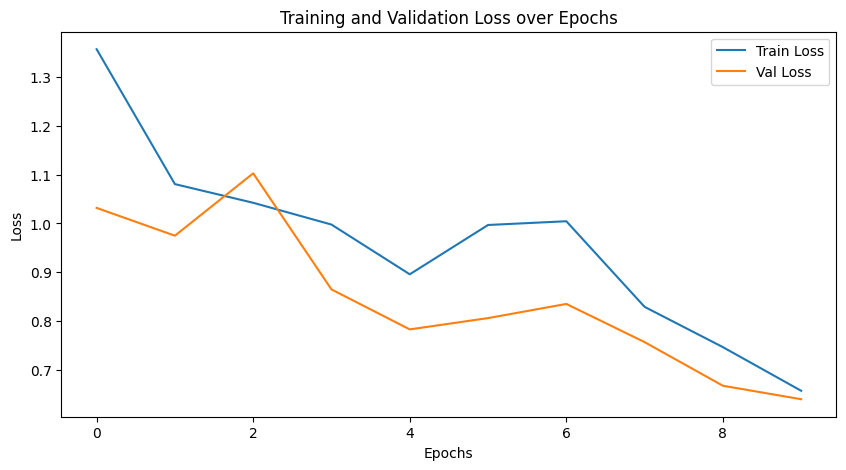

In [5]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

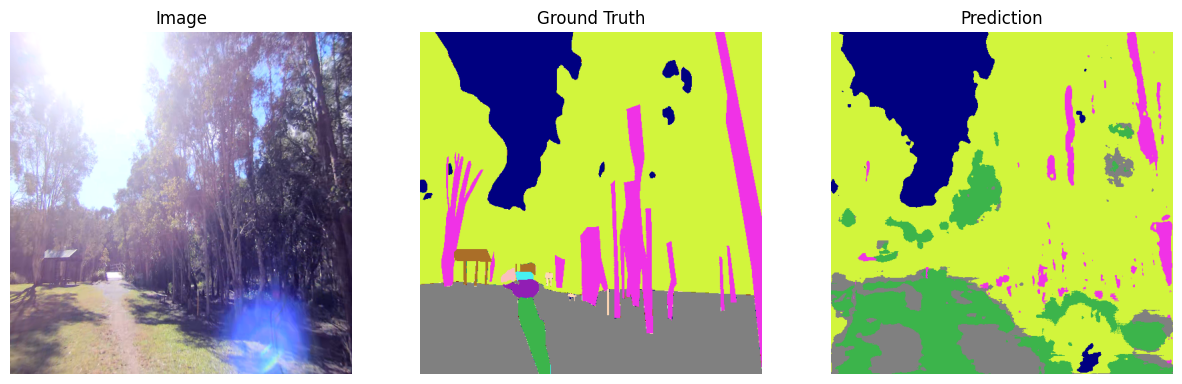

In [6]:
# Prediction on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image, sample_label = sample_image.to(device), sample_label.to(device)
prediction = model(sample_image)
prediction = prediction.argmax(dim=1)

# Visualization functions
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

# Visualize sample image, ground truth, and prediction
sample_image = sample_image[0].cpu().numpy().transpose((1, 2, 0))
sample_label = sample_label[0].cpu().numpy()
prediction = prediction[0].cpu().numpy()

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(sample_image)
plt.title("Image")
plt.axis('off')

plt.subplot(132)
plt.imshow(label_to_rgb(sample_label, METAINFO['palette']))
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(133)
plt.imshow(label_to_rgb(prediction, METAINFO['palette']))
plt.title("Prediction")
plt.axis('off')
plt.show()


In [7]:
# Function to calculate IoU for each class
def calculate_class_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_class = (y_true == cls)
        pred_class = (y_pred == cls)
        
        intersection = (true_class & pred_class).sum().item()
        union = (true_class | pred_class).sum().item()
        
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        
        ious.append(iou)
    
    return ious

# Evaluate the model
def evaluate_model(model, test_loader, classes):
    model.eval()
    class_ious = {cls: 0 for cls in classes}
    merged_classes = []
    merged_ious = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for pred, label in zip(preds, labels):
                pred = pred.cpu().numpy().flatten()
                label = label.cpu().numpy().flatten()

                for class_idx in np.unique(label):
                    if class_idx in np.unique(pred):
                        iou = calculate_class_iou(label, pred, len(classes))[class_idx]
                        class_ious[classes[class_idx]] += iou

    for class_name in classes:
        if class_name == "pole":
            other_object_idx = classes.index("other-object")
            class_ious[classes[other_object_idx]] += class_ious[class_name]
        elif class_name == "asphalt/concrete":
            other_terrain_idx = classes.index("other-terrain")
            class_ious[classes[other_terrain_idx]] += class_ious[class_name]
        elif class_name not in ["vehicle", "pole", "asphalt/concrete", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(class_ious[class_name])

    merged_class_ious = dict(zip(merged_classes, merged_ious))
    return merged_class_ious

# Evaluate the model
classes = METAINFO['classes']
merged_class_ious = evaluate_model(model, test_loader, classes)

# Print IoU results
print("\nClass-wise IoU:")
total_iou = 0
for class_name, iou in sorted(merged_class_ious.items()):
    total_iou += iou / len(test_loader.dataset) * 100
    print(f"Class {class_name:<20} IoU: {iou / len(test_loader.dataset) * 100:.4f}")

# Calculate Mean IoU
mean_iou = total_iou / 15
print(f"\nMean IoU: {mean_iou:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'model_unet.pth')
print("Model saved as 'model_unet.pth'")

Testing: 100%|██████████| 134/134 [11:28<00:00,  5.14s/it]


Class-wise IoU:
Class bush/shrub           IoU: 0.0000
Class dirt                 IoU: 51.6518
Class fence                IoU: 0.0000
Class grass                IoU: 35.9192
Class gravel               IoU: 0.0000
Class log                  IoU: 0.0000
Class mud                  IoU: 0.0000
Class other-object         IoU: 0.0000
Class other-structure      IoU: 0.0000
Class other-terrain        IoU: 0.0000
Class rock                 IoU: 0.0000
Class sky                  IoU: 49.8917
Class tree-foliage         IoU: 73.6926
Class tree-trunk           IoU: 29.8804
Class water                IoU: 0.0000

Mean IoU: 16.0691
Model saved as 'model_unet.pth'
